In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys 
import h5py
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
sys.path.append("/home/amisery/SemesterProject")
from data.data_utils import *

In [2]:
import matplotlib

In [3]:
font = {
        'weight' : 'normal',
        'size'   : 18}
rcparams = {
    "mathtext.default": "regular",
    "figure.figsize": (8.0, 8.0),
    "font.size": 24,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.fontsize": "small",
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "legend.frameon": False,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
    "xaxis.labellocation": "right",
    "yaxis.labellocation": "top",
}
for key in list(rcparams.keys()):
    matplotlib.rcParams[key] = rcparams[key]
    
matplotlib.rc('font', **font)
# matplotlib.rcParams['figure.figsize'] = (12, 9)
# matplotlib.rcParams["figure.autolayout"] = True

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
data_path = "/scratch2/sfgd/sparse_data_genie_fhc_numu_hittag/"
N_files = len(os.listdir(data_path))

In [6]:
N_files

310573

Let's check the content of the event files

In [7]:
f = np.load(data_path + 'event0.npz')
keys = list(f.keys())
print(keys)

['x', 'c', 'y', 'verPos']


In [8]:
len(f["y"])

238

In [9]:
for k in keys :
    print(f[k].shape)
print(f["verPos"])

(238, 12)
(238, 3)
(238, 1)
(3,)
[ -253.93285902    68.95139531 -1544.77885975]


Let's also check the created h5 file

In [10]:
hf = h5py.File("/home/amisery/out.h5", "r")

In [11]:
print(hf["event_hits_index"][N_files-1])
print(hf["event_hits_index"][4:None])
len(hf["coords"])-hf["event_hits_index"][-1]

55822319
[     741      823      906 ... 55821973 55822222 55822319]


21

In [12]:
def plot_stats(evt):
        fig, axs = plt.subplots(4,3, figsize = (10,10))
        i=0
        names = ["HitTime", "HitCharge", "HitMPPCXY", "HitMPPCXZ", "HitMPPCYZ","HitNumberXY", "HitNumberXZ", "HitNumberYZ", "HitAdjacent", "HitDiagonal", "HitCorner", "HitDistance2Vertex"]
        for idx,ax in enumerate(fig.axes):
                f_split = [evt["x"][(evt["y"]==j).squeeze(1),i] for j in range(1,4)]
                ax.hist(f_split, histtype= "barstacked", bins = 25, color = ["yellow", "red", "blue"])
                ax.set_title(names[i])
                i+=1
        fig.legend(["multi", "single", "other"])
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9,
                        wspace=0.4, 
                        hspace=0.4)
        plt.show()

        plt.clf()

        fig = plt.figure(figsize=(10,10))
        i = 1
        f_split = [evt["x"][(evt["y"]==j).squeeze(1),i] for j in range(1,4)]
        plt.hist(f_split, histtype= "barstacked", bins = 50, color = ["yellow", "red", "blue"], range = (0,100))
        plt.title(names[i])
        plt.show()


In [13]:
def display_3D(evt):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    for i in range(1,4):
        cat_coords = evt["c"][(evt["y"]==i).squeeze(1),:]
        ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [14]:
def display_3D_h5(evt_id):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    h_start, h_stop = hf["event_hits_index"][evt_id], hf["event_hits_index"][evt_id+1]
    rotmat = R.from_euler("XYZ", [np.pi/2,0,0]).as_matrix()
    coords = np.matmul(hf["coords"][h_start:h_stop],rotmat)
    vals = hf["labels"][h_start:h_stop]

    for i in range(1,4):
        cat_coords =coords[(vals==i).squeeze(1),:]
        ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")


In [15]:
def show_event(evt_id = None, plot_stat = False, h5 = False):
    #show a random event from a dataset
    if evt_id == None :
        evt_id = np.random.randint(1,N_files)
    evt = np.load(data_path + "event%d.npz"%evt_id)
    if h5:
        display_3D_h5(evt_id)
    else :
        display_3D(evt)
    plt.title("Event #%d, %d hits"%(evt_id, len(evt["c"])), fontsize = 16)
    plt.show()
    plt.clf()
    if plot_stat:
        plot_stats(evt)

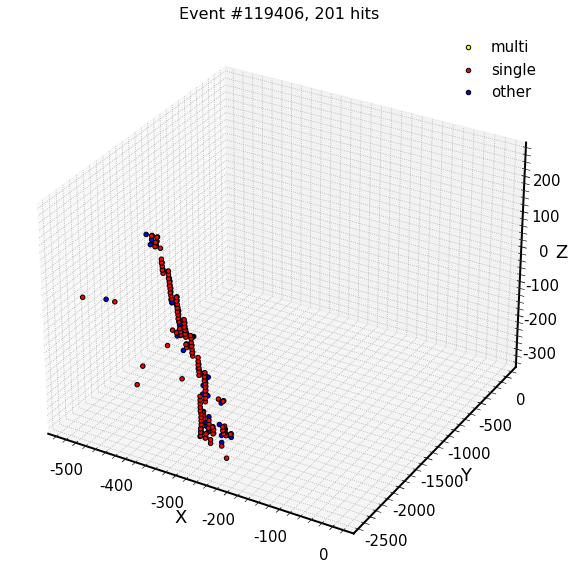

<Figure size 576x576 with 0 Axes>

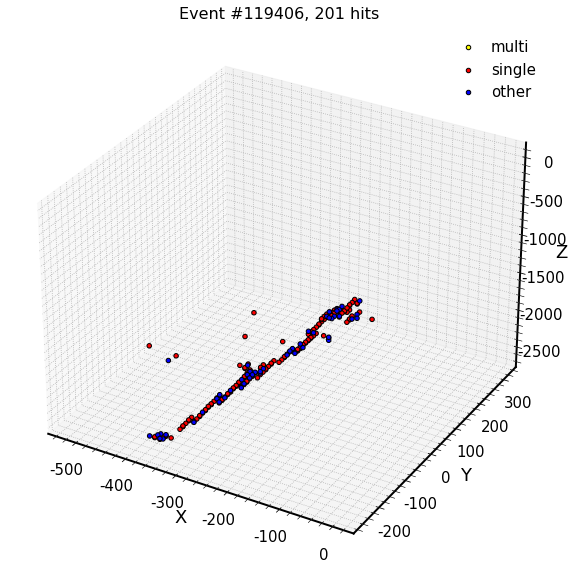

<Figure size 576x576 with 0 Axes>

In [16]:
evt_id = np.random.randint(1,N_files)
show_event(evt_id, h5=True)
show_event(evt_id)

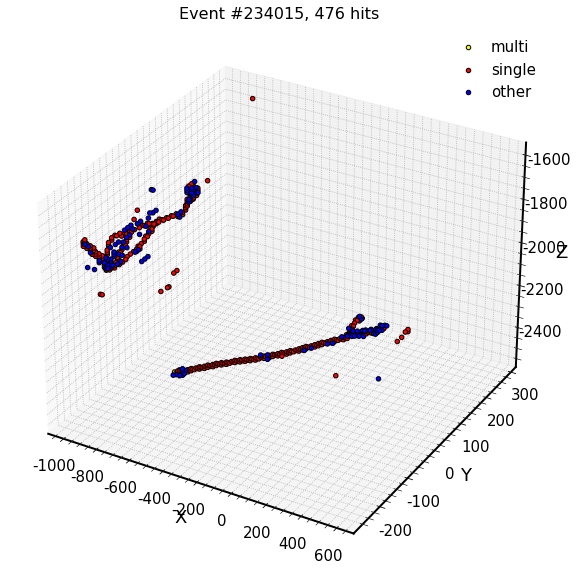

<Figure size 576x576 with 0 Axes>

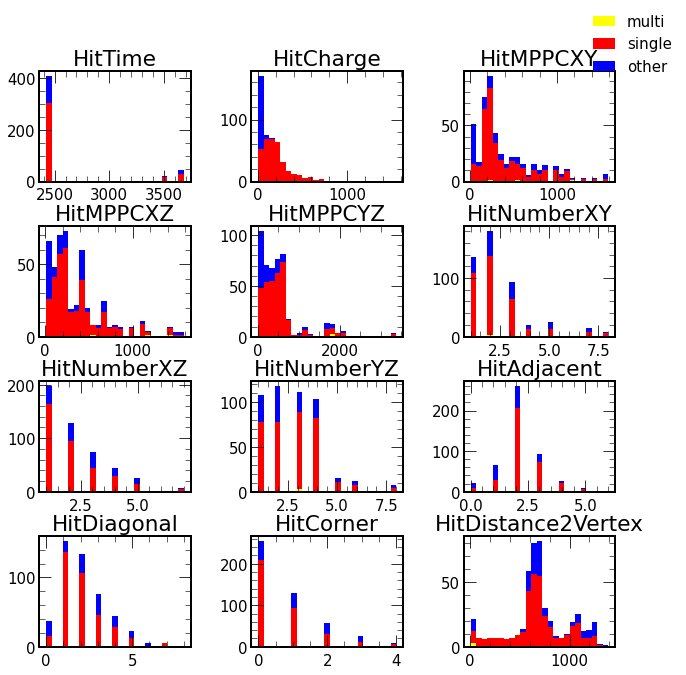

<Figure size 576x576 with 0 Axes>

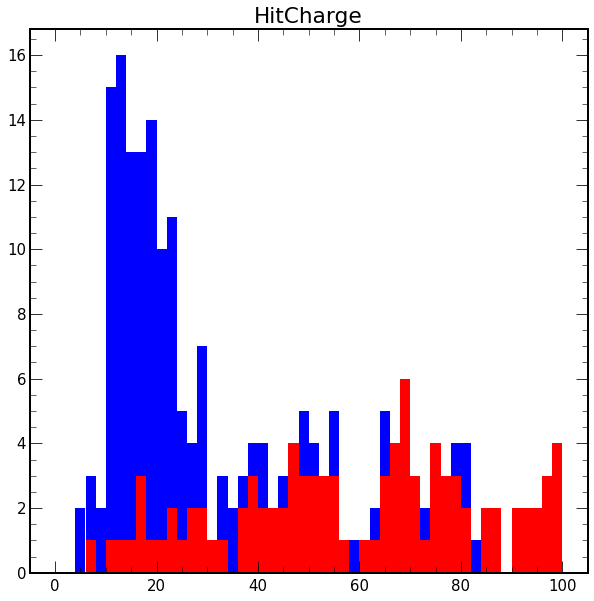

In [17]:
show_event(234015,plot_stat = True)

Global Dataset statistics

In [18]:
# lengths = []
# tot_charge = []
# max_dist_to_vertex = []
# charge_deposit = np.array([])
# for i in range(N_files):
#     evt = np.load(data_path + "event%d.npz"%i)
#     lengths.append(len(evt["x"]))
#     tot_charge.append(np.sum(evt["x"][:,1]))
#     max_dist_to_vertex.append(np.max(evt["c"].astype("float32")-evt["verPos"].astype("float32")))
#     charge_deposit = np.concatenate((charge_deposit,evt["x"][:,1]))
#     if i > 10000:
#         break
# plt.hist(lengths, bins = 50)


Speed comparison with the h5 dataset

Text(0, 1, 'Count')

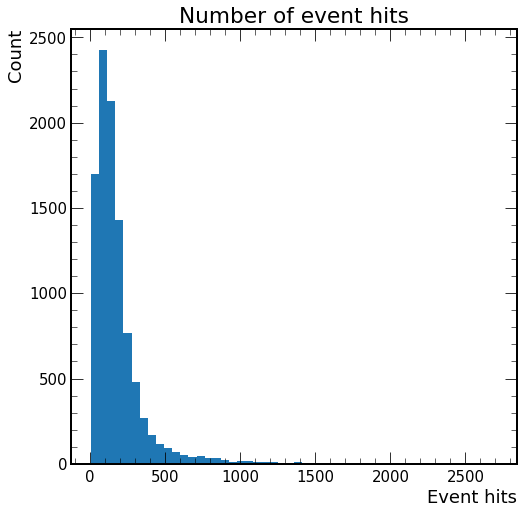

In [48]:
lengths = []
tot_charge = []
max_dist_to_vertex = []
mp_frac = []
sp_frac = []
n_frac = []
noise, single, multi = 0, 0, 0
charge_deposit = np.array([])
for i in range(N_files):
    h_start, h_stop = hf["event_hits_index"][i], hf["event_hits_index"][i+1]

    coords = hf["coords"][h_start:h_stop]
    charge = hf["charge"][h_start:h_stop]
    vals = hf["labels"][h_start:h_stop]
    mp_frac.append(np.sum(vals == 1)/len(vals))
    sp_frac.append(np.sum(vals==2)/len(vals))
    n_frac.append(np.sum(vals==2)/len(vals))
    noise += np.sum(vals == 3)
    single += np.sum(vals==2)
    multi += np.sum(vals==1)
    verpos = hf["verPos"][i]
    lengths.append(h_stop-h_start)
    tot_charge.append(np.sum(charge))

    max_dist_to_vertex.append(np.max(coords-verpos))
    charge_deposit = np.concatenate((charge_deposit,charge))
    if i > 10000:
        break
plt.hist(lengths, bins = 50)
plt.title("Number of event hits")
plt.xlabel("Event hits")
plt.ylabel("Count")


Text(0, 1, 'Count [a.u.]')

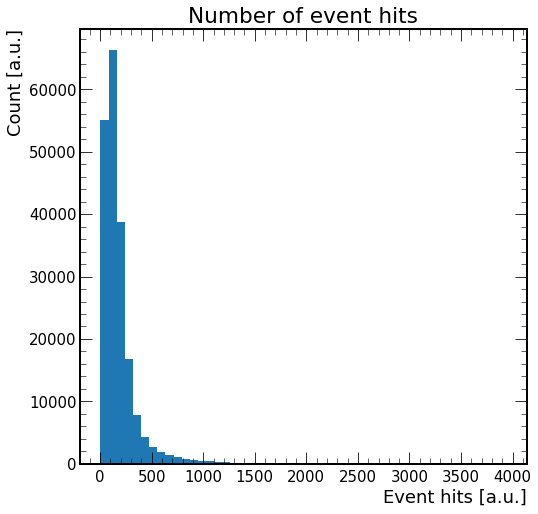

In [44]:
plt.hist(lengths, bins = 50)
plt.title("Number of event hits")
plt.xlabel("Event hits [a.u.]")
plt.ylabel("Count [a.u.]")

In [20]:
print("noise : %.3f ; single particule : %.3f ; multi : %.3f"%(noise/np.sum(lengths), single/np.sum(lengths), multi/np.sum(lengths)))

noise : 0.228 ; single particule : 0.752 ; multi : 0.020


In [21]:
single/noise, single/single, single/multi

(3.297880389081245, 1.0, 37.24093271297581)

Text(1, 0, '$E_{tot} [MeV]$')

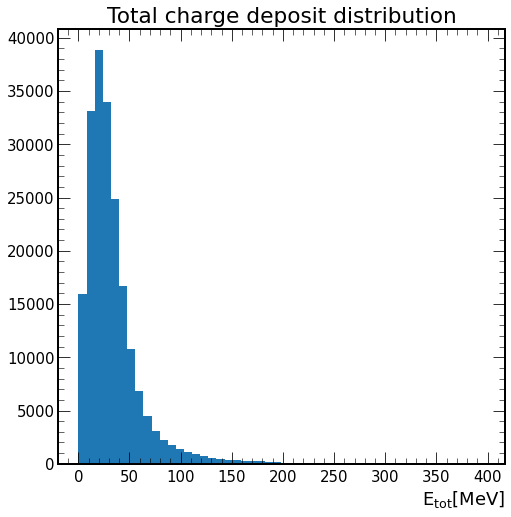

In [43]:
plt.hist(np.array(tot_charge)/1000, bins = 50)
plt.title("Total charge deposit distribution")
plt.xlabel("Count")
plt.xlabel(r"$E_{tot} [MeV]$")

In [45]:
charge_deposit

array([], dtype=float64)

Text(1, 0, '$E [a.u.]$')

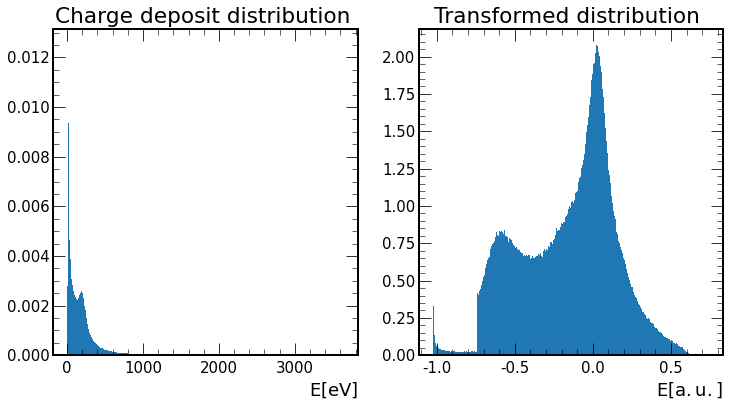

In [58]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.hist(charge_deposit, bins = 500, density = True)

ax.set_title("Charge deposit distribution ")
ax.set_xlabel(r"$E [eV]$")
ax1 = fig.add_subplot(1,2,2)
ax1.hist(charge_transform(charge_deposit), bins = 500, density = True)

ax1.set_title("Transformed distribution ")
ax1.set_xlabel(r"$E [a.u.]$")

Text(1, 0, '$E [eV]$')

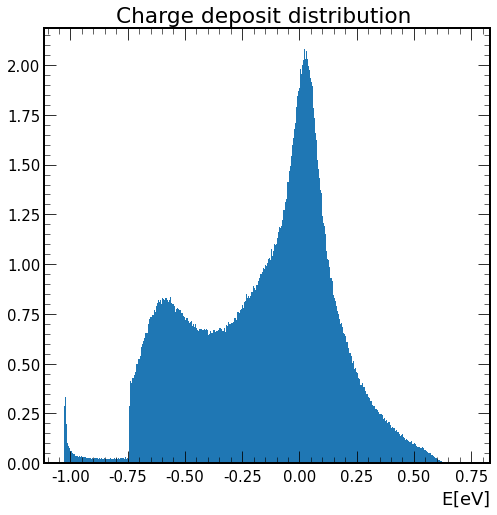

(array([ 18., 342., 359., 401., 491., 482., 489., 522., 481., 503., 507.,
        420., 407., 385., 349., 313., 237., 255., 270., 217., 193., 187.,
        180., 173., 164., 149., 127., 145., 136., 134., 103., 111.,  91.,
        105.,  98.,  68.,  68.,  77.,  53.,  48.,  57.,  50.,  16.,   3.,
          0.,   7.,   4.,   3.,   2.,   2.]),
 array([ -23.36319  ,   15.6632805,   54.68975  ,   93.716225 ,
         132.74269  ,  171.76917  ,  210.79564  ,  249.8221   ,
         288.84857  ,  327.87503  ,  366.90152  ,  405.92798  ,
         444.95447  ,  483.98093  ,  523.0074   ,  562.0339   ,
         601.06036  ,  640.0868   ,  679.1133   ,  718.1398   ,
         757.1662   ,  796.1927   ,  835.2192   ,  874.2456   ,
         913.2721   ,  952.2986   ,  991.325    , 1030.3516   ,
        1069.3779   , 1108.4044   , 1147.4309   , 1186.4574   ,
        1225.4839   , 1264.5104   , 1303.5367   , 1342.5632   ,
        1381.5897   , 1420.6162   , 1459.6427   , 1498.6692   ,
        1537.6957 

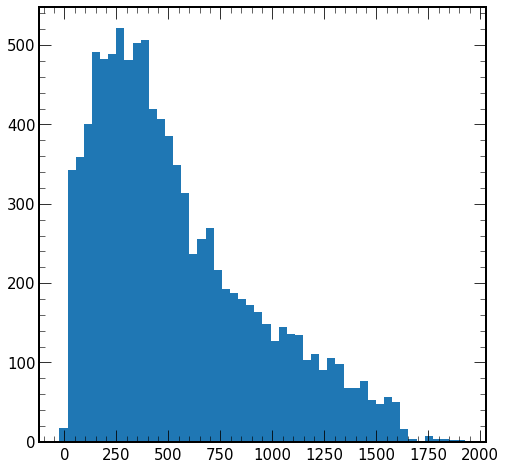

In [49]:
plt.hist(max_dist_to_vertex, bins = 50)

In [25]:
np.mean(max_dist_to_vertex)

542.14264

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.18333333, 0.2       , 0.21666667, 0.23333333,
        0.25      , 0.26666667, 0.28333333, 0.3       , 0.31666667,
        0.33333333, 0.35      , 0.36666667, 0.38333333, 0.4       ,
        0.41666667, 0.43333333, 0.45      , 0.46666667, 0.48333333,
        0.5       , 0.51666667, 0.53333333, 0.55      , 0.56666667,
        0.58333333, 0.6       , 0.61666667, 0.63333333, 0.65      ,
        0.66666667, 0.68333333, 0.7       , 0.71666667, 0.73333333,
        0.75      , 0.76666667, 0.78333333, 0.8       , 0.81666667,
        0.83333333, 0.85      , 0.86666667, 0.

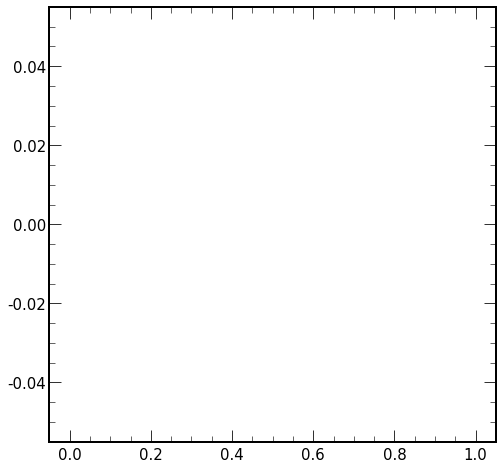

In [26]:
plt.hist(np.log(charge_deposit/185)/4, bins = 60)

In [27]:
np.mean(charge_deposit)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

Testing a simple pytorch dataset from directly loading the npz files

In [28]:
import torch
from torch.utils.data import Sampler, RandomSampler, Dataset, BatchSampler

In [29]:
loss_fn = torch.nn.CrossEntropyLoss()
pred = torch.randn((32,1))
target = torch.randn((32,1))
loss_fn(pred,target)

tensor(-0.)

Experimenting with self attention and other layers

In [30]:
seq_length = 4
emb_dim = 8

X = torch.randn(emb_dim, seq_length)

W = torch.randn(emb_dim, emb_dim)
b = torch.randn(emb_dim, seq_length)
perm = torch.randperm(seq_length)

X_perm = X[:,perm]
print(perm)
print(torch.matmul(W,X) +b - (torch.matmul(W, X_perm)+b)[:,perm])
print(b)

tensor([0, 2, 3, 1])
tensor([[ 0.0000, -2.2561, -2.7898,  5.0459],
        [ 0.0000, -1.3397,  3.0275, -1.6878],
        [ 0.0000, -0.3909, -0.8009,  1.1918],
        [ 0.0000, -0.8781, -0.8855,  1.7636],
        [ 0.0000,  9.9774, -1.6696, -8.3078],
        [ 0.0000, -2.4444,  0.5108,  1.9335],
        [ 0.0000, -0.5527,  2.3781, -1.8254],
        [ 0.0000, -2.0386, -2.4894,  4.5280]])
tensor([[-0.2324,  0.6056, -0.4130,  0.7221],
        [-0.7261, -2.1277, -1.3674, -0.0326],
        [-1.2611, -0.8102, -1.5014, -0.3637],
        [ 1.1526,  1.1444,  0.0108, -1.9133],
        [ 1.8702,  0.6125,  1.1813, -0.4231],
        [ 0.5289,  0.1825, -0.3337, -0.8805],
        [-0.1486,  0.8062, -0.5886, -0.6141],
        [ 0.0651,  0.5911, -1.1940,  0.2680]])


In [31]:
lin = torch.nn.Linear(emb_dim,emb_dim, bias = False)
print(torch.transpose(X,0,1))
print(torch.transpose(X_perm,0,1))
print(lin(torch.transpose(X,0,1)) - lin(torch.transpose(X_perm,0,1)))


tensor([[-1.2088e-02, -9.4082e-03,  1.5093e+00, -1.3510e-01, -3.6397e-01,
          8.2570e-01,  3.3249e-01,  1.2335e+00],
        [-3.7562e-01, -5.1103e-01, -8.0138e-02,  1.6277e+00, -8.2296e-02,
         -2.5099e-01,  2.5999e-01, -2.0970e-01],
        [-3.5121e-01, -6.6127e-01, -2.2268e-04,  1.5195e+00,  1.8125e+00,
         -2.8306e-01, -1.7322e-01,  1.5155e-01],
        [ 1.0443e+00, -1.1524e+00,  1.1218e-01, -9.7708e-01, -9.0295e-01,
         -5.3777e-01, -1.5649e-01,  1.9471e+00]])
tensor([[-1.2088e-02, -9.4082e-03,  1.5093e+00, -1.3510e-01, -3.6397e-01,
          8.2570e-01,  3.3249e-01,  1.2335e+00],
        [-3.5121e-01, -6.6127e-01, -2.2268e-04,  1.5195e+00,  1.8125e+00,
         -2.8306e-01, -1.7322e-01,  1.5155e-01],
        [ 1.0443e+00, -1.1524e+00,  1.1218e-01, -9.7708e-01, -9.0295e-01,
         -5.3777e-01, -1.5649e-01,  1.9471e+00],
        [-3.7562e-01, -5.1103e-01, -8.0138e-02,  1.6277e+00, -8.2296e-02,
         -2.5099e-01,  2.5999e-01, -2.0970e-01]])
tensor([[ 0.00

In [32]:
from models.transformer_encoder import EncoderLayer,Model
enc_lay = EncoderLayer(64,32,64//16, dropout = 0.01)
x = torch.ones(1,5,4)
mask = torch.ones(1,5)

model = Model(64,32,4,5,4,3)
model(x,mask)

ImportError: cannot import name 'EncoderLayer' from 'models.transformer_encoder' (/home/amisery/SemesterProject/models/transformer_encoder.py)